<a href="https://colab.research.google.com/github/Sshubam/PyTorch-Code/blob/main/PyTorch_12_SimpleRNN_Sinwaveipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import numpy as np 
import matplotlib.pyplot as plt

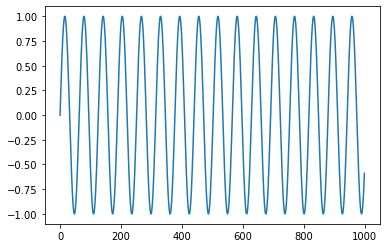

In [ ]:
N = 1000
series = np.sin(0.1*np.arange(N)) 
plt.plot(series)
plt.show()

In [ ]:
T = 10
X = []
Y = []
for t in range(len(series)-T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)
print("Len(X)", len(X))

X.shape (990, 10, 1) Y.shape (990, 1)
Len(X) 990


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
class SimpleRNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(SimpleRNN, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    self.rnn = nn.RNN(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        nonlinearity="relu",
        batch_first=True
    )
    self.fc = nn.Linear(self.M, self.K)

  def forward(self, X):
      h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
      out, _ = self.rnn(X, h0)
      out = self.fc(out[:, -1, :])
      return out

In [ ]:
model  = SimpleRNN(n_inputs=1, n_hidden=5, n_rnnlayers=1, n_outputs=1)
model.to(device)

SimpleRNN(
  (rnn): RNN(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [ ]:
X_train = torch.from_numpy(X[:N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [ ]:
print("X_train", len(X_train), "y_train", len(y_train), "X_test", len(X_test), "y_test", len(y_test))

X_train 495 y_train 495 X_test 495 y_test 495


In [ ]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [ ]:
#Train the model

def full_gd(
    model,
    criterion,
    optimizer,
    X_train,
    y_train,
    X_test,
    y_test,
    epochs=200):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    train_losses[it] = loss.item()
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[it] = test_loss.item()
    
    if (it):
      print(f"Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss:{test_loss.item():.4f}")

  return train_losses, test_losses

In [ ]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

Epoch 2/200, Train Loss: 0.5997, Test Loss:0.4705
Epoch 3/200, Train Loss: 0.4617, Test Loss:0.3175
Epoch 4/200, Train Loss: 0.3118, Test Loss:0.1702
Epoch 5/200, Train Loss: 0.1677, Test Loss:0.0661
Epoch 6/200, Train Loss: 0.0662, Test Loss:0.0746
Epoch 7/200, Train Loss: 0.0743, Test Loss:0.1069
Epoch 8/200, Train Loss: 0.1054, Test Loss:0.1468
Epoch 9/200, Train Loss: 0.1475, Test Loss:0.0857
Epoch 10/200, Train Loss: 0.0867, Test Loss:0.0227
Epoch 11/200, Train Loss: 0.0232, Test Loss:0.0051
Epoch 12/200, Train Loss: 0.0052, Test Loss:0.0181
Epoch 13/200, Train Loss: 0.0180, Test Loss:0.0386
Epoch 14/200, Train Loss: 0.0384, Test Loss:0.0544
Epoch 15/200, Train Loss: 0.0541, Test Loss:0.0588
Epoch 16/200, Train Loss: 0.0583, Test Loss:0.0527
Epoch 17/200, Train Loss: 0.0522, Test Loss:0.0418
Epoch 18/200, Train Loss: 0.0413, Test Loss:0.0295
Epoch 19/200, Train Loss: 0.0291, Test Loss:0.0192
Epoch 20/200, Train Loss: 0.0190, Test Loss:0.0128
Epoch 21/200, Train Loss: 0.0128, Test 

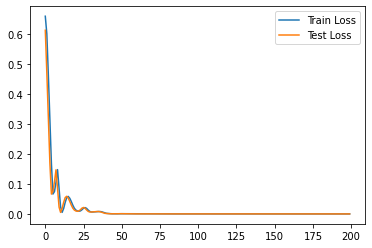

In [ ]:
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()
plt.show()

In [ ]:
T

10

In [ ]:
last_x = X_test[0].view(T)
last_x

tensor([-0.6929, -0.6174, -0.5358, -0.4489, -0.3574, -0.2624, -0.1647, -0.0654,
         0.0345,  0.1341])

In [ ]:
#Forecast future values

validation_target = Y[-N//2:]
validation_predictions = []

last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
  input_ = last_x.reshape(1, T, 1)
  p = model(input_)
  validation_predictions.append(p[0, 0].item())
  last_x = torch.cat((last_x[1:], p[0]))

In [ ]:
last_x = torch.cat((last_x[1:], p[0])) #changes every time because it takes last elements
last_x

tensor([-0.8290, -0.7734, -0.7150, -0.6532, -0.5875, -0.5174, -0.5174, -0.5174,
        -0.5174, -0.5174], grad_fn=<CatBackward>)

In [ ]:
validation_target.shape

(495, 1)

In [ ]:
len(validation_predictions)

495

In [ ]:
input_

tensor([[[-0.9889],
         [-0.9787],
         [-0.9572],
         [-0.9244],
         [-0.8807],
         [-0.8290],
         [-0.7734],
         [-0.7150],
         [-0.6532],
         [-0.5875]]], grad_fn=<ViewBackward>)

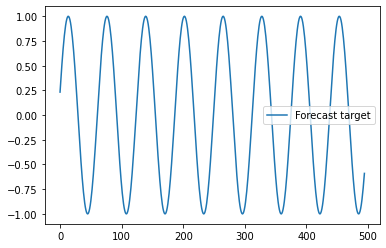

In [ ]:
plt.plot(validation_target, label="Forecast target")
plt.legend()

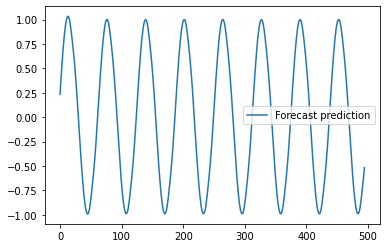

In [ ]:
plt.plot(validation_predictions, label = "Forecast prediction")
plt.legend()